In [3]:
# import libraries 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patches as mpatches
import pickle
import math

from sklearn.cluster import DBSCAN, OPTICS

In [46]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

my_colors_2 = ['#88292F','#12355B' , '#697268', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap_2 = LinearSegmentedColormap.from_list('custom_cmap_2', my_colors_2)

In [5]:
# import clean data set

df_subset = pd.read_csv('df_subset.csv')

In [6]:
df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1


In [7]:
pca_df = pd.read_csv('pca_df.csv')

In [51]:
pca_df.head()

,PC1,PC2
0,-1.253143,-0.763049
1,-0.374977,-1.197599
2,1.976068,-0.386187
3,-1.228114,-1.370854
4,1.454437,-1.465956


# Density based clustering

## DBSCAN

In [52]:
# Define the DBSCAN parameters
eps = 0.9
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the model to the data
dbscan.fit(pca_df)

# Get the labels of the data points
labels = dbscan.labels_


In [53]:
with open('results/density_based/dbscan.pickle', 'wb') as f:
    pickle.dump(dbscan, f)

In [54]:
labels += 1

df_subset['cluster_label'] = labels
pca_df['cluster_label'] = labels

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,1


In [55]:
df_subset['cluster_label'].unique()

array([1, 0])

In [56]:
df_subset.to_csv('results/density_based/csv_labels_cut_raw/DBSCAN.csv', index=False)

In [57]:
most_frequent_clusters = df_subset.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster_label labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster_label')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,1
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,1
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,1


In [58]:
df_subset['cluster_label'].unique()

array([1])

In [59]:
df_subset.to_csv('results/density_based/labels_most_common/DBSCAN.csv', index=False)

In [60]:
representative_points = df_subset.groupby(['asset_id']).first().reset_index()

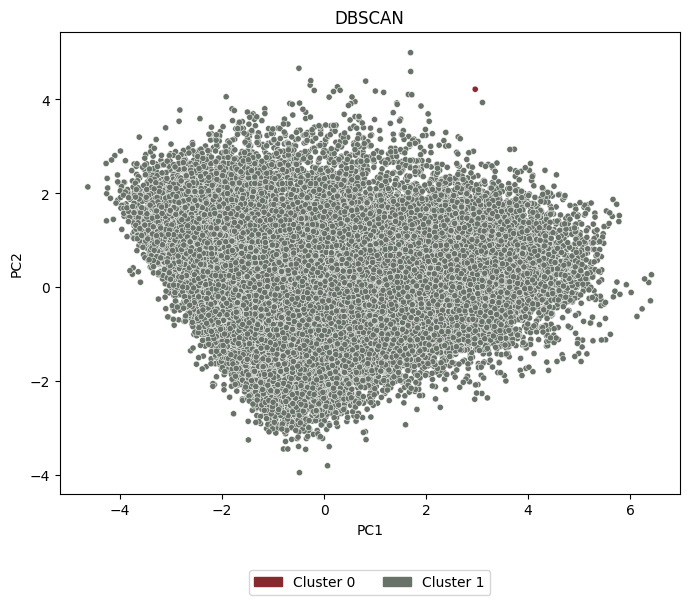

In [62]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('DBSCAN')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

this behaviour was expected due to the already known faults of density based algorithms in high dimensional data, large data sets and relatively equal density

In [65]:
representative_points = df_subset.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.80,227.00,80.00,8.41,12.00,21.00,1,1
1,12,1663674600,2.80,65.00,15.00,6.38,23.00,36.00,1,1
2,13,1623918000,2.40,-95.00,8.00,5.89,13.00,29.00,1,1
3,14,1674150600,16.50,-65.00,2056.00,18.00,5.00,13.00,1,1
4,15,1663676400,3.10,76.00,29.00,7.02,25.00,40.00,1,1
...,...,...,...,...,...,...,...,...,...,...
66,414,1676895600,2.40,-252.00,5.00,5.45,15.00,21.00,4,1
67,415,1636346400,4.90,-285.00,173.00,10.16,8.00,15.00,4,1
68,510,1628030400,4.91,313.39,198.62,8.34,17.08,24.11,5,1
69,511,1621104600,8.52,244.07,1321.08,13.85,14.55,17.69,5,1


In [66]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


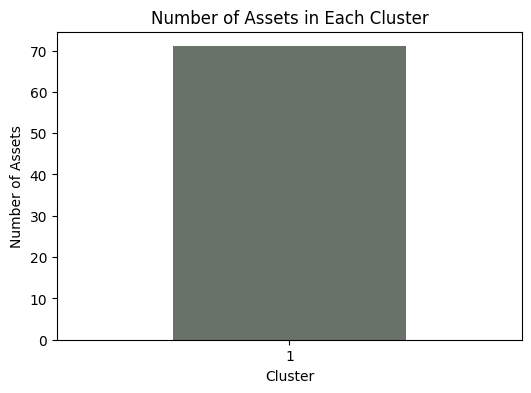

In [67]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [90]:
pca_df = pca_df.loc[:, :'PC2']
df_subset = df_subset.loc[:, : 'farm']

## OPTICS

In [32]:
optics = OPTICS(min_samples=2, min_cluster_size=math.ceil(len(pca_df)/10)).fit(pca_df)

In [33]:
with open('results/density_based/optics.pickle', 'wb') as f:
    pickle.dump(optics, f)

In [34]:
optics_labels = optics.labels_ +1

In [12]:
with open('results/density_based/optics.pickle', 'rb') as f:
    optics = pickle.load( f)

In [35]:
df_subset['cluster_label'] = optics_labels
pca_df['cluster_label'] = optics_labels

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,1
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,2
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,2
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,1
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,2


In [37]:
df_subset['cluster_label'].nunique()

3

In [38]:
df_subset.to_csv('results/density_based/csv_labels_cut_raw/OPTICS.csv', index=False)

In [39]:
most_frequent_clusters = df_subset.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster_label labels back to the original DataFrame
df_subset = df_subset.drop(columns='cluster_label')

df_subset = pd.merge(df_subset, most_frequent_clusters, on='asset_id', how='left')

df_subset.head()

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.8,227.0,80.0,8.41,12.0,21.0,1,2
1,11,1614628200,5.2,231.0,165.0,9.93,5.0,20.0,1,2
2,11,1636269600,8.6,61.0,1013.0,16.26,7.0,12.0,1,2
3,11,1646093400,3.4,245.0,45.0,7.44,7.0,21.0,1,2
4,11,1613958000,7.0,271.0,571.0,14.35,0.0,12.0,1,2


In [40]:
df_subset['cluster_label'].unique()

array([2])

In [41]:
df_subset.to_csv('results/density_based/labels_most_common/OPTICS.csv', index=False)

In [42]:
representative_points = df_subset.groupby(['asset_id']).first().reset_index()

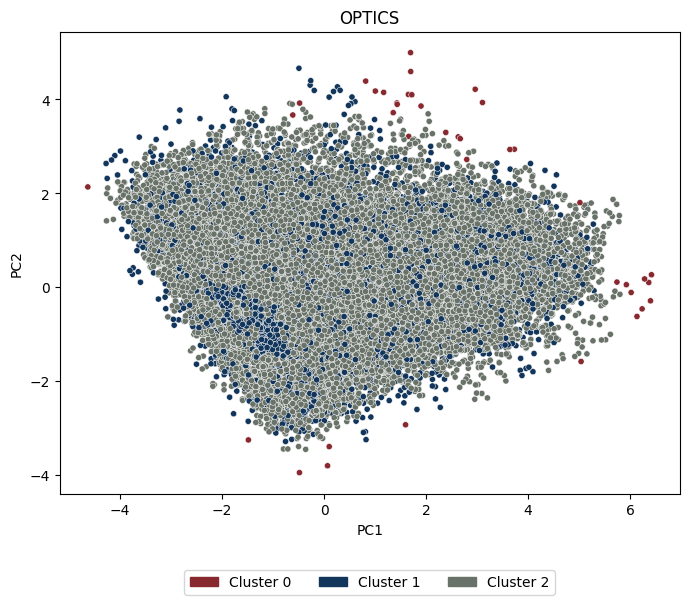

In [47]:
n_clusters = pca_df['cluster_label'].nunique()
pallete = sns.color_palette(my_colors_2, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('OPTICS')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors_2]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(optics_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=100)
plt.show()

In [48]:
representative_points = df_subset.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,read_at,wind_speed,wind_direction,power_average,rotation_average,exterior_temperature,nacelle_temperature,farm,cluster_label
0,11,1641199200,3.80,227.00,80.00,8.41,12.00,21.00,1,2
1,12,1663674600,2.80,65.00,15.00,6.38,23.00,36.00,1,2
2,13,1623918000,2.40,-95.00,8.00,5.89,13.00,29.00,1,2
3,14,1674150600,16.50,-65.00,2056.00,18.00,5.00,13.00,1,2
4,15,1663676400,3.10,76.00,29.00,7.02,25.00,40.00,1,2
...,...,...,...,...,...,...,...,...,...,...
66,414,1676895600,2.40,-252.00,5.00,5.45,15.00,21.00,4,2
67,415,1636346400,4.90,-285.00,173.00,10.16,8.00,15.00,4,2
68,510,1628030400,4.91,313.39,198.62,8.34,17.08,24.11,5,2
69,511,1621104600,8.52,244.07,1321.08,13.85,14.55,17.69,5,2


In [49]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


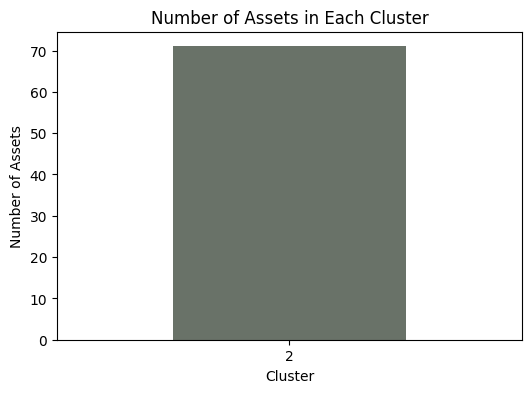

In [50]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [51]:
pca_df = pca_df.loc[:, :'PC2']
df_subset = df_subset.loc[:, : 'farm']